# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implementing ε-Greedy and UCB

In [2]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """

    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [3]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        if (narms <= 0):
            raise ValueError('Number of arms must be a greater than zero.')   
        if not ((epsilon >= 0) and (epsilon <= 1)):
            raise ValueError('epsilon must be a probability.')   
            
        # This maintains the accumlated rewards
        # for each arm.
        self.accumulated_reward = np.full((narms), 0)
        # This calculate number of times each arm is picked.
        self.arm_picked = np.full((narms), 0)
        # Input argument describing number of arms.
        self.narms = narms

        self.Q0 = Q0
        self.epsilon = epsilon
        
    def Qfunction(self):
        # This calculates the actual Q function based on if the arm
        # has been picked or not picked yet.
        # If arm is not picked, we used the Q0 as our Q value for that arm.
        # If arm is picked then, mean reward observed is used as the Qvalue for that arm.
        qvals = np.zeros(self.narms)
        for i in range(self.narms):
            # If arm is not currently picked use the old value value provided by Q0
            if (self.arm_picked[i] == 0):
                qvals[i] = self.Q0
            else:
                # Calculate the value for Q using accumulated rewards if arm was ever picked.
                qvals[i] = self.accumulated_reward[i]/self.arm_picked[i]
        return qvals
        
    def play(self, tround, context=None):
        if (tround <= 0):
            raise ValueError('tround must be a positive integer.')   
        # Choose whether to explore (with probabilty epsilon) and exploit rest of the time.
        try_new = np.random.choice([1,0],p=[self.epsilon, 1-self.epsilon])
        if try_new:
            return np.random.randint(low=1, high=self.narms)
        else:
            # This calculates the Q value for each arm.
            Q = self.Qfunction()
            # Pick randomly out of arm with maximum value. 
            # flatnonzero : Return indices that are non-zero as we want to tie-break randomly
            # which is done using random.choice function.
            # Increment index to match the spec.
            return np.random.choice(np.flatnonzero(Q == Q.max())) + 1
        
    def update(self, arm, reward, context=None):
        if not ((arm > 0) and (arm <= self.narms)):
            raise ValueError('arm must be in {1, ...., self.narms}.')   
        # Since accumulated rewards are initalized with zero. We can directly maintain
        # sum of average reward. We preferred using a simpler implementation we could just maintain
        # running average reward for each arm aswell.
        
        # Internally for convinence we maintain rewards from 0 to n-1. 
        # We are substracting 1 from the arm index to match implementation
        # as python index starts from zero.
        self.accumulated_reward[arm - 1] += reward
        self.arm_picked[arm - 1] += 1
        
    

In [4]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        if (narms <= 0):
            raise ValueError('Number of arms must be a greater than zero.')   
        if (rho <= 0):
            raise ValueError('rho must be a positive real explore-exploit parameter.')
        # This maintains the accumlated rewards
        # for each arm.
        self.accumulated_reward = np.full((narms), 0)
        # This calculate number of times each arm is picked.
        self.arm_picked = np.full((narms), 0)
        # Input argument describing number of arms.
        self.narms = narms        
        self.Q0 = Q0        
        self.rho = rho

    
    def play(self, tround, context=None):
        if (tround <= 0):
            raise ValueError('tround must be a positive integer.')   
        qvals = np.zeros(self.narms)
        for i in range(self.narms):
            if (self.arm_picked[i] == 0):
                qvals[i] = self.Q0
            else:
                # This is upper confidence bound clalculation based on Hoeffding's inequality.
                # This tries to maintain a balance between arm which are explored.
                cal_ucb = np.sqrt(self.rho*(np.log(tround)/self.arm_picked[i]))
                # Calculate the Q Value with average reward observed and upper confidence bound.
                qvals[i] = (self.accumulated_reward[i]/self.arm_picked[i]) + cal_ucb
        # Select arm similar to EpsGreedy, tie-breaking randomly.
        return np.random.choice(np.flatnonzero(qvals == qvals.max())) + 1

        
    def update(self, arm, reward, context=None):
        if not ((arm > 0) and (arm <= self.narms)):
            raise ValueError('arm must be in {1, ...., self.narms}.')   
        # Since accumulated rewards are initalized with zero. We can directly maintain
        # sum of average reward. We preferred using a simpler implementation we could just maintain
        # running average reward for each arm aswell.
        self.accumulated_reward[arm-1] += reward
        self.arm_picked[arm-1] += 1
 
    

## 2. The Basic Thompson Bandit

In [5]:
class BetaThompson(MAB):
    """
    Beta-Bernoulli Thompson sampling multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    alpha0 : float, optional
        positive real prior hyperparameter

    beta0 : float, optionala
        positive real prior hyperparameter
    """
    
    def __init__(self, narms, alpha0=1.0, beta0=1.0):
        if (narms <= 0):
            raise ValueError('Number of arms must be a greater than zero.')   
        if (alpha0 <= 0):
            raise ValueError('alpha0 must be a positive real prior hyperparameter.')
        if (beta0 <= 0):
            raise ValueError('beta0 must be a positive real prior hyperparameter.')
        self.alpha = alpha0
        self.beta = beta0
        # This maintains the accumlated rewards
        # for each arm.
        self.accumulated_reward = np.full((narms), 0)
        # This calculate number of times each arm is picked.
        self.arm_picked = np.full((narms), 0)
        # Input argument describing number of arms.
        self.narms = narms
        
    def play(self, tround, context=None):
        if (tround <= 0):
            raise ValueError('tround must be a positive integer.')   
        sampled_means = np.zeros(self.narms)
        for arm in range(self.narms):
            success = self.accumulated_reward[arm]
            failure = self.arm_picked[arm] - success
            # Sample from the posterior distribution. Since this is we know the form of posterior
            # analytically. We didn't maintain the prior and directly sampled the mean 
            # fromm of posterior while sampling.
            sampled_means[arm] = np.random.beta(success + self.alpha , failure + self.beta)
        # Paper mentions to do tie- breaking arbitrary.
        return np.random.choice(np.flatnonzero(sampled_means == sampled_means.max())) + 1
        
        
    def update(self, arm, reward, context=None):
        if not ((arm > 0) and (arm <= self.narms)):
            raise ValueError('arm must be in {1, ...., self.narms}.')   
        # Algorithm asks to sample a bernoulli taking reward as probability.
        # This is not higly relevant for us as our rewards are already 0 and 1.
        # But it gives the same answe as we sample 1 with probability 1.
        # Hence we implemented generic version of the algorithm which is present in Algorithm 2 in 
        # paper.
        reward_bernoulli = np.random.choice([1,0],p=[reward, 1-reward])
        if reward_bernoulli:
            self.accumulated_reward[arm - 1] += 1
        self.arm_picked[arm - 1] += 1


## 3. Off-Policy Evaluation

In [6]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    
    #################  NOTE  ###################################################
    # Since our Multi arm bandit works with arm id 0-N
    # This log file is based on arm ids 1 to N.  
    # We reset the arm id in Bandit classes to confer with spec of provided abstract class.
    ############################################################################
    
    # Check input is in right format.
    if not isinstance(mab, MAB):
        raise ValueError("First argument must be instance of Multi Arm bandit abstract class MAB.")
    if not arms.ndim == 1:
        raise ValueError("Arms need to be 1D float array, shape (nevents,)")
    if not rewards.ndim == 1:
        raise ValueError("Reward need to be 1D float array, shape (nevents,)")
    if not contexts.ndim == 2:
        raise ValueError("Contexts need to be 2D float array. shape (nevents, mab.narms*nfeatures)")
    if not ((len(arms) == len(rewards)) and (len(arms) == len(contexts))):
        raise ValueError("Arms, Contexts and Rewards should be equal in size.")

    total_reward = []
    current_event = 0
    max_events = len(arms)
    
    # If number of rounds are not provided.
    # Considering each event becomes a round.
    # Setting reasonable maximum number of rounds.
    if not nrounds:
        nrounds = max_events
    # Iterate through all the round
    for event in range(nrounds):
        # event is incremented in a new round and not number of event from log file. 
        pulled_arm = mab.play(event + 1, contexts[current_event])
        # We only consider and use events where our player arm matches with in logs.
        while(pulled_arm != arms[current_event]):
            current_event += 1
            # If we have exhausted total number of events then return total rewards.
            if (current_event >= max_events):
                return total_reward
            # Since LinUCB used context. We need to play and get new arm for each new event.
            pulled_arm = mab.play(event + 1, contexts[current_event])
        mab.update(arms[current_event], rewards[current_event], contexts[current_event])
        total_reward.append(rewards[current_event])
        # Since last event matched and we have performed update for that. increment, without this
        # we reuse old event which isn't desirable.
        current_event += 1
        # If we have exhausted total number of events then return total rewards.
        if (current_event >= max_events):
            return total_reward
    return total_reward

In [7]:
arms = []
rewards = []
contexts = []
# Read the file line by line and splot on space
# Based on spec provided for dataset.txt
with open('dataset.txt') as f:
    line = f.readline()
    while line:
        line_splits = line.split(' ')
        arms.append(int(line_splits[0]))
        rewards.append(int(line_splits[1]))
        contexts.append(np.array(line_splits[2:-1]))
        line = f.readline()

# Make arms, rewards and context as per spec of classes.
arms = np.array(arms)
rewards = np.array(rewards)
contexts = np.array(contexts)

In [8]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.175


In [9]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.1525


In [10]:
mab = BetaThompson(10, 1.0, 1.0)
results_BetaThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('BetaThompson average reward', np.mean(results_BetaThompson))

BetaThompson average reward 0.2275


## 4. Contextual Bandits - LinUCB

In [11]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):    
        # Check inputs 
        if (narms <= 0):
            raise ValueError('Number of arms must be a greater than zero.')   
        if (alpha <= 0):
            raise ValueError("alpha needs to be positibe real explore-exploit parameter.")
        if not (ndims > 0):
            raise ValueError("number of dimensions for each arm's context need to be positive")
            
        # This maintains the accumlated rewards
        # for each arm.
        self.accumulated_reward = np.full((narms), 0)
        # This calculate number of times each arm is picked.
        self.arm_picked = np.full((narms), 0)
        # Input argument describing number of arms.
        self.narms = narms
        self.alpha = alpha
        self.ndims = ndims
        
        # Inverse of A acts as covariance matrix on feature space.
        self.A = [np.identity(ndims) for _ in range(narms)]
        # This tracks the accumulated rewards as weights (guassian means) are
        # considered the linear model.
        self.b = [np.zeros((ndims,1))  for _ in range(narms)]
        
    def play(self, tround, context):
        if (tround <= 0):
            raise ValueError('tround must be a positive integer.')   
        if not context.ndim == 1:
            raise ValueError("Context need to be 1D float array, shape (self.ndims * self.narms)")
        # Reshape the context into 10x10 matrix to have 10 feature for each arm
        # As we need to do regression and as we need to do matrix manipulation below.
        context = context.reshape((10,10), order='C').astype(int)
        
        # Initialize q function with zeros to calculate q function below.
        current_q = np.zeros(self.narms)
        for arm in range(self.narms):
            a_inverse = np.linalg.inv(self.A[arm])
            # Find the means using ridge regression.
            theta = a_inverse@self.b[arm]
            curr_context = np.array(context[arm]).reshape(self.ndims,1)
            current_sd = curr_context.T@(a_inverse@curr_context)
            # Calculate the Q value using mean and standard-deviation as we consider setup like ridge regression.
            current_q[arm] = (theta.T)@curr_context + self.alpha*np.sqrt(current_sd[0][0])
            
        # Ties broken arbirary.
        return np.random.choice(np.flatnonzero(current_q == current_q.max())) + 1
    
    def update(self, arm, reward, context):
        if not context.ndim == 1:
            raise ValueError("Context need to be 1D float array, shape (self.ndims * self.narms)")
        if not ((arm > 0) and (arm <= self.narms)):
            raise ValueError('arm must be in {1, ...., self.narms}.')   

        # Reshape context to match 10x10 for matrix multication.
        # Further convert the context to column vector.
        context = context.reshape((10,10), order='C').astype(int)
        curr_context = np.array(context[arm-1]).reshape(self.ndims,1)
        # Update positerior for ridge regression.
        self.A[arm-1] += curr_context@(curr_context.T)
        self.b[arm-1] += reward*curr_context
    

In [12]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 5. Contextual Bandits - LinThompson

In [13]:
class LinThompson(MAB):
    """
    Contextual Thompson sampled multi-armed bandit (LinThompson)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    v : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, v):
        if (narms <= 0):
            raise ValueError('Number of arms must be a greater than zero.')   
        if (v <= 0):
            raise ValueError("v must be positive real number representing explore-exploit parameter")
        if not (ndims > 0):
            raise ValueError("number of dimensions for each arm's context need to be positive")
            
        # This maintains the accumlated rewards
        # for each arm.
        self.accumulated_reward = np.full((narms), 0)
        # This calculate number of times each arm is picked.
        self.arm_picked = np.full((narms), 0)
        # Input argument describing number of arms.
        self.narms = narms

        # Intialize Parameters for our multivariate normal.
        # Single mu and B are maintained as conceptually this algorithm
        # works on infinite number of arms with slighly worse regret bounds.
        self.B = np.identity(ndims)
        self.mu = np.zeros(ndims)
        self.f = np.zeros((ndims,1))
        self.v = v
        self.ndims = ndims
       
        
    def play(self, tround, context):
        if (tround <= 0):
            raise ValueError('tround must be a positive integer.')   
        if not context.ndim == 1:
            raise ValueError("Context need to be 1D float array, shape (self.ndims * self.narms)")
        # Reshape the context into 10x10 matrix to have 10 feature for each arm
        # As we need to do regression and as we need to do matrix manipulation below.
        context = context.reshape((10,10), order='C').astype(int)
        current_q = np.zeros(self.narms)
        
        # Sample params for regression using the current mean and co-variance 
        # from multi-variate normal via Thompson sampling. 
        sampled_params = np.random.multivariate_normal(self.mu, (self.v**2)*np.linalg.inv(self.B))
        
        for arm in range(self.narms):
            # Reshape context as colum vector for calculating the q function.
            curr_context = np.array(context[arm]).reshape(self.ndims,1)
            # Expected rewards are considered linear function of rewards.
            # We get the current Q value using the context and sampled parameters
            # from multi-variate gaussian.
            current_q[arm] = (curr_context.T)@sampled_params
        return np.random.choice(np.flatnonzero(current_q == current_q.max())) + 1
       
    def update(self, arm, reward, context):
        if not context.ndim == 1:
            raise ValueError("Context need to be 1D float array, shape (self.ndims * self.narms)")
        if not ((arm > 0) and (arm <= self.narms)):
            raise ValueError('arm must be in {1, ...., self.narms}.')   
        context = context.reshape((10,10), order='C').astype(int)
        curr_context = np.array(context[arm - 1]).reshape(self.ndims,1)
        # Update expected rewards, mean similar to LinUCB.
        # Update parameter based on positerior
        self.B += curr_context@(curr_context.T)
        self.f += reward*curr_context
        # Update to get the posterior mean
        self.mu = (np.linalg.inv(self.B)@self.f).reshape(self.ndims)
    

In [14]:
mab = LinThompson(10, 10, 1.0)
results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinThompson average reward', np.mean(results_LinThompson))

LinThompson average reward 0.325


## 6. Evaluation
### 6.A.

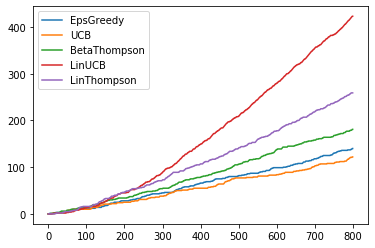

In [15]:
def get_cumulative(result):
    return [sum(result[0:i]) for i in range(len(result))]

results_EpsGreedy_cum = get_cumulative(results_EpsGreedy)
plt.plot(results_EpsGreedy_cum, label='EpsGreedy')

results_UCB_cum = get_cumulative(results_UCB)
plt.plot(results_UCB_cum, label='UCB')

results_BetaThompson_cum = get_cumulative(results_BetaThompson)
plt.plot(results_BetaThompson_cum, label='BetaThompson')

results_LinUCB_cum = get_cumulative(results_LinUCB)
plt.plot(results_LinUCB_cum, label='LinUCB')

results_LinThompson_cum = get_cumulative(results_LinThompson)
plt.plot(results_LinThompson_cum, label='LinThompson')

plt.legend()
plt.show()

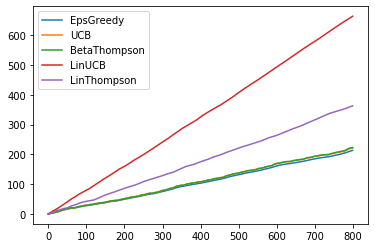

In [16]:
# Since above results are on single run and it's better to consider averaged results over many episodes.
# We calculate results by averaging over 100 episodes.
# Resuts by averaging over 100 episods
def run_100_episods(mab):
    results=[]
    for i in range(100):
        results.append(offlineEvaluate(mab, arms, rewards, contexts, 800))
    results_array = np.array(results)
    mean_results = np.mean(results_array, axis=0)
    return get_cumulative(mean_results)

results_EpsGreedy_100 = run_100_episods(EpsGreedy(10, 0.05))
plt.plot(results_EpsGreedy_100, label='EpsGreedy')

results_UCB_100 = run_100_episods(UCB(10, 1.0))
plt.plot(results_UCB_100, label='UCB')

results_BetaThompson_100 = run_100_episods(BetaThompson(10, 1.0, 1.0))
plt.plot(results_BetaThompson_100, label='BetaThompson')

results_LinUCB_100 = run_100_episods(LinUCB(10, 10, 1.0))
plt.plot(results_LinUCB_100, label='LinUCB')

results_LinThompson_100 = run_100_episods(LinThompson(10, 10, 1.0))
plt.plot(results_LinThompson_100, label='LinThompson')

plt.legend()
plt.show()

**Expaination from above graph:** This gives us better view of how alogirthms performs against each other EpsilonGreedy, UCB, BetaThompson perform very close to each other unlike instantitious graph above which shows a lot of variation. 

### 6.B.

Max value of LinThompson is  0.46625  at v =  0.10354137931034484
Max value of LinUCB is  0.7325  at alpha =  0.05182068965517242


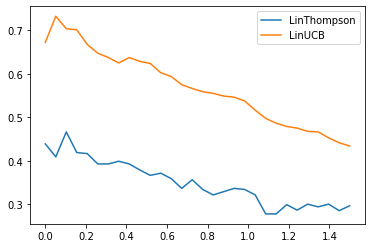

In [17]:
# Even though the parameter range for v and alpha is unbounded. Initial tinkering with large step size
# relvealed than it keeps decreasing after value of 1. 
# So here we consider only a small range from 0.0001 to 1.5 on linear space with 30 values.
# Since the range of both the similar hyper-parameter range. We draw them on same graph.
# Grid Search for v in LinThompson
grid_v = np.linspace(0.0001,1.5,num=30)
# Grid Search for alpha in LinUCB
grid_alpha = np.linspace(0.0001,1.5,num=30)
results_grid_v = np.zeros(grid_v.shape[0])
results_grid_alpha = np.zeros(grid_alpha.shape[0])
for i in range(grid_v.shape[0]):
    mab = LinThompson(10, 10, grid_v[i])
    results_grid_v[i] = np.mean(offlineEvaluate(mab, arms, rewards, contexts, 800))
for i in range(grid_alpha.shape[0]):
    mab = LinUCB(10, 10, grid_alpha[i])
    results_grid_alpha[i] = np.mean(offlineEvaluate(mab, arms, rewards, contexts, 800))

# Since both are working on the similar range, we used single graph.
plt.plot(grid_v, results_grid_v, label='LinThompson')
plt.plot(grid_alpha, results_grid_alpha, label='LinUCB')
print("Max value of LinThompson is ", np.max(results_grid_v), " at v = ", grid_v[np.argmax(results_grid_v)])
print("Max value of LinUCB is ", np.max(results_grid_alpha), " at alpha = ", grid_alpha[np.argmax(results_grid_alpha)])
plt.legend()
plt.show()